# **COMP3670/6670 Assignment 3 - GMM**
---

**Enter Your Student ID:** u6826541

**Your Name:** yixi rao
    

**Submit:** You can write your answers in this file and submit a single Jupyter Notebook file (.ipynb) on Wattle. Rename this file with your student number as 'uXXXXXXX.ipynb'. Otherwise, you can write your programming questions in this file, and submit two files, 'uXXXXXXX.ipynb' for programming and 'uXXXXXXX.pdf' for theory. Please submit them separately instead of a zip file.
    
**Enter Discussion Partner IDs Below:**
- <Enter ID 1>
- <Enter ID 2>
- <Enter ID 3>
    

**Programming Section**
- 1 = 20%
- 2 = 20%
- 3 = 20%
- 4 = 7.5%
- 5 = 7.5%
- 6.1 = 5%
- 6.2 = 20%

---


**PROGRAMMING SECTION**
---


For all of the following, program the solution yourself. Don't just call a library function that does the whole question for you, or you'll get zero (no, that doesn't mean you can't use any library functions, but it does mean that you have to show you understand how to compute the answer yourself).

-----------

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #This is for 3d scatter plots.
from scipy.stats import multivariate_normal
import math
import random
import functools

We're going to implement an algorithm to model data with a mixture of gaussians. 

Remember the simplified EM algorithm in assignment 2 for k-means? Well, we're going to implement something similar.

The more complex aspect of this all is that your program must also correctly estimate the covariance matrices of the 2-dimensional gaussian components involved, as well as their means.

Not only this, but the "distance" of each of your data points (a row $d_i$ of $D$) from a gaussian $k$, is the probability of that point given that gaussian $p(d_i \mid k)$. 

Run the below cell to load the data we'll be using.

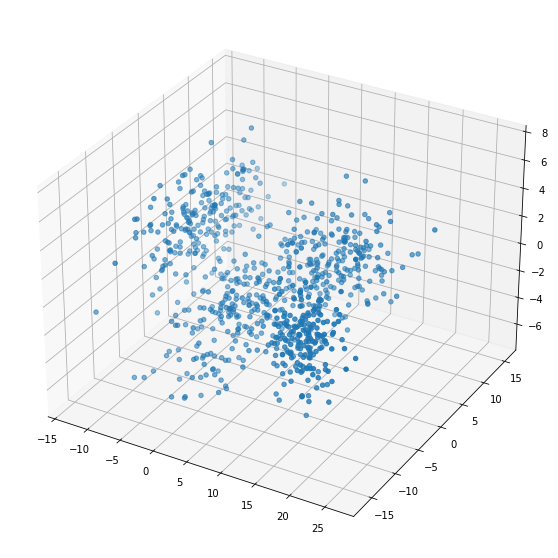

In [164]:
X = np.load("./data.npy")
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:, 2])
plt.show()

First off, some definitions:

$X$ is a dataset contains 800 data. Each data has 5 dimensions. The contribution of first three dimensions represented by a three dimensional Gaussian Mixture Model. The forth and fifth dimensions represented by another two dimensional GMM. 

**You only need the first three dimensions of the data in task 1 through 5. The fourth and fifth dimensions are for task 6 only.**.

$K$ is the total number of gaussians. This is just like the $K$ means you had for k-means in assignment 2. Each gaussian is named $k$, where $k$ is the unique number associated with that gaussian. For example, the first gaussian is $k = 1$. Each $k$ has a mean and covariance matrix associated with it. This allows you to construct a gaussian which is just a formula which can be used to generate data points or to compute the probability that a given data point is generated from this gaussian (look up generative models if you're curious to learn more). For this purpose, you can use np.random.multivariate_normal().

$\Sigma$ is a list of covariance matrices $\Sigma_k \in \mathbb{R}^{m \times m}$, which are symmetric positive semidefinite matrices.

$\mu$ is a list of means, each one $\mu_k \in \mathbb{R}^{m}$ associated with gaussian $k$.

$N$ is the total number of datapoints.

$responsibilities \in [0, 1]^{N \times K}$ is a matrix. Every column $k$ of $responsibilities$ is associated with the $k^{th}$ gaussian. Each element $r_{ik}$ of the $k^{th}$ column is the probability of the $i^{th}$ datapoint $x_i$ (the $i^{th}$ row of $X$) given the gaussian $k$.

$N_k$ is the sum of the $k^{th}$ column of $responsibilities$. In other words, there is one $N_k$ for each gaussian. $N_k = \sum_i r_{ik}$.

$\pi$ is a list of probabilities, 1 associated with each gaussian. $\pi_k$ is the probability of gaussian $k$. $\pi_k = \frac{N_k}{N}$.

---

   **TASK 1:** Complete the below function to initialise your parameters. You will need to generate:
   1. A list $\mu$ of $K$ means, each of which is in $\mathbb{R}^{m}$.
   2. A list $\Sigma$ of $K$ covariance matrices in $\mathbb{R}^{m \times m}$. Remember, covariance matrices must be symmetric positive semidefinite.
   3. A list $\pi$ of $K$ probabilities $\pi_k$. They should be initialised at $\frac{1}{K}$ (uniformly distributed at first).

Do not hard code parameters. You should generate them with some randomness, and your code must work for any $m$, $k$ and $N$.

You need to intelligently select $\mu_k$ just like you did with k-means. Poorly initialised parameters may result in an entirely broken EM algorithm.

**REPEAT: You only need the first three dimensions of the data in task 1 through 5. The fourth and fifth dimensions are for task 6 only.**.

---

In [165]:
def initialise_parameters(X, K):
    dim   = X.shape[1]
    sigma = np.zeros((K, dim, dim))
    pi    = np.array([1/K for _ in range(K)])
    
    #!KNN
    C = X[np.random.choice(X.shape[0], 4)]
    r = np.random.randint(20,40)
    while r > 0:
        #?E_step
        num_point = X.shape[0]
        Lables    = []
        for i in range(0, num_point):
            d = X[i]
            c = min([(np.sqrt(sum((x - d)**2)), i) for i, x in enumerate(C)])[1]
            
            Lables.append(C[c])
        L = np.array(Lables)
        #?M_step
        Lable_dict = dict([(tuple(c),[]) for c in C])
        for i in range(0, L.shape[0]):
            Lable_dict[tuple(L[i])].append(X[i])
            
        for j in range(0, C.shape[0]):
            all_cluster_v = Lable_dict[tuple(C[j])]
            C[j]          = np.array(sum(all_cluster_v) / len(all_cluster_v))
        r = r - 1
    mu = C
    
    for ki in range(K):
        ran_M     =  np.random.rand(dim, dim)
        sigma[ki] = ran_M @ ran_M.T + dim * np.eye(dim, dim) # algorithm reference: https://math.stackexchange.com/questions/357980/how-to-generate-random-symmetric-positive-definite-matrices-using-matlab

    return sigma, mu, pi
   
K = 4
sigma, mu, pi = initialise_parameters(X[:, :3], K)
print('\nSigma: \n', sigma)
print('\nMu: \n', mu)
print('\nPi: \n', pi)


Sigma: 
 [[[4.14364215 0.92839518 1.45857875]
  [0.92839518 4.21827224 1.22287918]
  [1.45857875 1.22287918 4.87654859]]

 [[3.55828127 0.58714856 0.32311232]
  [0.58714856 3.88350548 0.45037207]
  [0.32311232 0.45037207 3.32748944]]

 [[4.32400941 0.75426356 1.3040788 ]
  [0.75426356 4.14474054 0.65895256]
  [1.3040788  0.65895256 4.31304399]]

 [[3.88007761 0.40057324 0.74290817]
  [0.40057324 3.65904423 0.81425033]
  [0.74290817 0.81425033 4.54541579]]]

Mu: 
 [[ 11.30048288   2.88380192   0.51713467]
 [ 15.89610759 -10.37176267  -0.03074552]
 [ -6.8648811    0.72926467   1.56825557]
 [  1.02011514  -4.56885321  -2.83437022]]

Pi: 
 [0.25 0.25 0.25 0.25]


$E\_step$ computes the matrix $responsibilities \in [0, 1]^{N \times K}$, where $N$ is the number of data points, and $K$ is the number of gaussians you're attempting to cluster the data with. Each gaussian will be associated with a column of $responsibilities$. As your algorithm runs, each row represents a data point $x_i$, and each column of that row will contain the probability that $x_i$ came from that gaussian, $p(x_i \mid k)$, signifying the extent to which this datapoint $x_i$ has been assigned to the gaussian associated with that column. 

---

**TASK 2:** Implement $E\_step(\pi, \mu, \Sigma, X) = responsibilities$, which updates the $responsibilities$ matrix.

Remember, which gaussian a datapoint is assigned to depends on the probability of that datapoint given that gaussian.

You cannot use euclidean distance like you did with the k-means algorithm in assignment 2.

**HINT:** 
- Each element of responsibilities $r_{ik} = \frac{\pi_k \mathcal{N}(x_i \mid \mu_k \Sigma_k)}{\sum_j \pi_j \mathcal{N}(x_i \mid \mu_j \Sigma_j)}$, where $x_i$ is the $i^{th}$ row of $X$.
- https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html
- Use $multivariate\_normal.pdf(x, \mu_k, \Sigma_k)$

---

In [166]:
def E_step(pi, mu, sigma, X):
    N = X.shape[0]
    K = pi.shape[0]

    r = np.zeros((N, K))
    for i in range(N):
        xi   = X[i]
        GMM  = sum([pi[k] * multivariate_normal.pdf(xi, mu[k], sigma[k]) for k in range(K)])
        r[i] = np.asarray([(pi[k] * multivariate_normal.pdf(xi, mu[k], sigma[k])) / GMM for k in range(K)])
        
    return r

responsibilities = E_step(pi, mu, sigma, X[:, :3])
print(responsibilities)
print(np.sum(responsibilities, axis=0)/800)

[[5.01694738e-09 9.99999970e-01 1.13588543e-29 2.53883293e-08]
 [2.80214579e-19 1.00000000e+00 5.56559077e-57 9.73531455e-27]
 [3.11657607e-19 1.00000000e+00 9.97846912e-58 1.51037698e-25]
 ...
 [9.99999521e-01 1.74771101e-11 1.57039288e-18 4.78514984e-07]
 [9.99999999e-01 1.93034020e-10 1.56755301e-22 1.19203790e-09]
 [9.99998068e-01 1.39622715e-14 5.45625818e-18 1.93164251e-06]]
[0.26611246 0.24302579 0.26888269 0.22197906]


---

**TASK 3:** Implement $M\_step(responsibilities, X) = \mu, \Sigma, \pi$ which returns the updated means and covariances for all of the $k$ gaussians, along with the priors $\pi$.

**HINT:** 
- https://docs.scipy.org/doc/numpy/reference/generated/numpy.outer.html

---

In [167]:
def M_step(r, X):
    K = r.shape[1]
    N = X.shape[0]
    
    pi    = np.sum(r, axis=0) / N
    mu    = np.asarray([(1 / (pi[k] * N)) * sum([X[n] * r[n, k] for n in range(N)]) for k in range(K)])
    sigma = np.asarray([(1 / (pi[k] * N)) * sum([r[n, k] * (X[n] - mu[k]).reshape(-1,1) @ (X[n] - mu[k]).reshape(-1,1).T for n in range(N)]) for k in range(K)])

    return mu, sigma, pi


mu, sigma, pi = M_step(responsibilities, X[:, :3])
print('\nSigma: \n', sigma)
print('\nMu: \n', mu)
print('\nPi: \n', pi)


Sigma: 
 [[[17.7689747   0.55172278  3.34657848]
  [ 0.55172278  3.02944728  0.72333878]
  [ 3.34657848  0.72333878  5.11387861]]

 [[11.10875391 -3.97357216  1.82513057]
  [-3.97357216  3.18899778 -0.39873965]
  [ 1.82513057 -0.39873965  4.59809099]]

 [[ 3.73230446  4.94776395  0.22031316]
  [ 4.94776395 24.22967388 -0.77983685]
  [ 0.22031316 -0.77983685  4.89152184]]

 [[10.53812048  2.04785868  1.98656451]
  [ 2.04785868 13.45599628  3.64080314]
  [ 1.98656451  3.64080314  3.39887376]]]

Mu: 
 [[ 11.27552435   2.79813718   0.43889489]
 [ 15.95459525 -10.36126468  -0.02896512]
 [ -6.88042686   0.65806391   1.59322334]
 [  1.00655921  -4.45085323  -2.78304859]]

Pi: 
 [0.26611246 0.24302579 0.26888269 0.22197906]


---

**TASK 4:** Implement $classify(\pi, \mu, \Sigma, x) = k$ which takes an unknown example $x \in \mathbb{R}^{m}$, the means $\mu$ and covariance matrices $\Sigma$ and the priors $\pi$, and returns $k$, the number of the gaussian which maximises the probability of $x$.

In other words, ${arg max}_k \left(p(x \mid \mu_k, \Sigma_k)\pi_k \right)$.

---

In [168]:
def classify(pi, mu, sigma, x):
    K = pi.shape[0]
    return np.argmax([pi[k] * multivariate_normal.pdf(x, mu[k], sigma[k]) for k in range(K)])

print(classify(pi, mu, sigma, X[270, :3]))

2


---

**TASK 5:** Implement $EM(X, K, iterations) = \mu, \Sigma, \pi$ which: 
1. takes a dataset $X \in \mathbb{R}^{N \times m}$ and $K$, an integer indicating how many gaussians will be used to cluster the data, and $iterations$ the number of iterations to be performed.
2. uses all of the functions you completed above to initialise parameters and find the optimal means $\mu$, covariances $\Sigma$ and priors $\pi$ to cluster the data points (a gaussian mixture model).

---


Sigma: 
 [[[ 1.35991114e+01  4.47531893e+00  1.67855541e+00]
  [ 4.47531893e+00  1.62319597e+01  4.50174831e+00]
  [ 1.67855541e+00  4.50174831e+00  3.38447099e+00]]

 [[ 2.35895627e+00  4.80924405e+00  7.93438891e-01]
  [ 4.80924405e+00  2.52426423e+01 -9.85091867e-01]
  [ 7.93438891e-01 -9.85091867e-01  4.48889856e+00]]

 [[ 1.90463910e+01  1.94820569e-02  2.83065509e+00]
  [ 1.94820569e-02  2.15251408e+00  7.24207192e-02]
  [ 2.83065509e+00  7.24207192e-02  4.72683937e+00]]

 [[ 1.34788255e+01 -5.19112865e+00  2.11180805e+00]
  [-5.19112865e+00  3.27691024e+00 -5.41118930e-01]
  [ 2.11180805e+00 -5.41118930e-01  4.58632860e+00]]]

Mu: 
 [[  1.12657373  -3.59816978  -2.68716898]
 [ -7.12760227   0.65758125   1.77495502]
 [ 11.56432894   2.96846759   0.65294711]
 [ 15.60635802 -10.25423986  -0.07113109]]

Pi: 
 [0.24965554 0.25277791 0.245771   0.25179554]


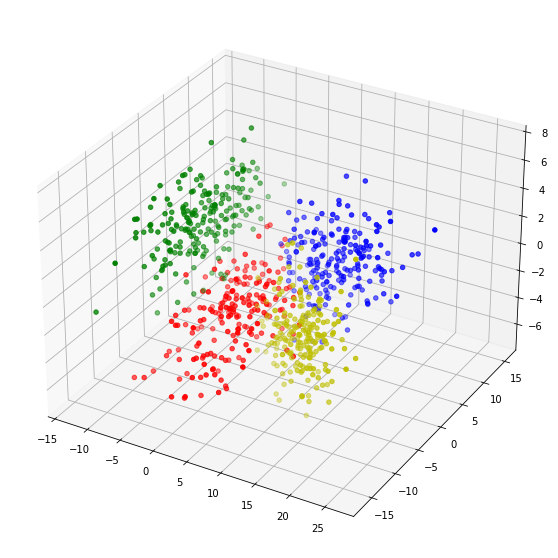

In [169]:
def EM(X, K, iterations):
    sigma, mu, pi = initialise_parameters(X, K)
    
    while iterations > 0:
        r = E_step(pi, mu, sigma, X)
        mu, sigma, pi = M_step(r, X)
        iterations = iterations - 1
    
    return mu, sigma, pi


#Test code. Leave it aloooooone!
iterations = 30
K = 4
mu_1, sigma_1, pi_1 = EM(X[:, :3], K, iterations)
print('\nSigma: \n', sigma_1)
print('\nMu: \n', mu_1)
print('\nPi: \n', pi_1)

def allocator(pi, mu, sigma, X, k):
    N = X.shape[0]
    cluster = []
    for ix in range(N):
        prospective_k = classify(pi, mu, sigma, X[ix, :])
        if prospective_k == k:
            cluster.append(X[ix, :])
    return np.asarray(cluster)

colours = ['r', 'g', 'b', 'y']
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
for k in range(K):
    cluster = allocator(pi_1, mu_1, sigma_1, X[:, :3], k)
    ax.scatter(cluster[:,0], cluster[:,1], cluster[:, 2], c=colours[k])
plt.show()

Now we start to use the forth and fifth dimension. First, we plot the forth and fifth dimension.

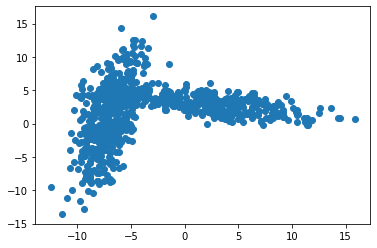

In [170]:
plt.scatter(X[:,3], X[:,4])
plt.show()

It is clearly that the number of Gaussians (K) for the second GMM equals to 2.

**TASK 6.1:** Compute the $\mu, \pi, \Sigma$ of the second GMM

In [171]:
mu_2, sigma_2, pi_2 = EM(X[:, 4:], 2, iterations)

**TASK 6.2:** Conditional Distribution.

Using the function from the Task 4. Using the $\mu, \pi, \Sigma$ to calculate the conditional distribution.

Let $K$ stands for the classification result of the first three dimensions, $Y$ stands for the classification result of the second dimensions.

Possible $k$ values are 0, 1, 2, 3. Possible $y$ values are 0, 1. 

Compute the conditional distribution $p(Y = y|K = k)$.

In [172]:
def conditional_distribution(X, k, y, mu_1, pi_1, sigma_1, mu_2, pi_2, sigma_2):
    return len([1 for x in X if classify(pi_1, mu_1, sigma_1, x[0:3]) == k and classify(pi_2, mu_2, sigma_2, x[4:]) == y]) / len([1 for xi in X[:, 0:3] if classify(pi_1, mu_1, sigma_1, xi) == k])

In [173]:
a = conditional_distribution(X, 0, 0, mu_1, pi_1, sigma_1, mu_2, pi_2, sigma_2)
b = conditional_distribution(X, 0, 1, mu_1, pi_1, sigma_1, mu_2, pi_2, sigma_2)
print(a + b) # The answer should equal(or almost equal) to one.

1.0
